In [1]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [2]:
homepath = os.getcwd() + '/'
print ('homepath: ' + homepath)

toppath = 'kdata/redux/'
print ('toppath:  ' + toppath)

path = 'kdata/redux/sample/'
print ('path:     ' + path)

fullpath = homepath + path
print ('fullpath: ' + fullpath)

homepath: /Users/mikewalker/fastai/nbs/
toppath:  kdata/redux/
path:     kdata/redux/sample/
fullpath: /Users/mikewalker/fastai/nbs/kdata/redux/sample/


In [64]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from shutil import copyfile

In [4]:
# Import our class, and instantiate
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [5]:
batch_size = 4

## Create Validation Set and Sample

Assumes 2 directories containing training (train) and testing (test) images

In [6]:
os.chdir(homepath + toppath)
print (os.getcwd())

/Users/mikewalker/fastai/nbs/kdata/redux


In [7]:
%mkdir 'valid'
%mkdir 'results'
%mkdir 'test/unknown'
%mkdir 'submission'
%mkdir 'sample'
%mkdir 'sample/train'
%mkdir 'sample/valid'
%mkdir 'sample/results'
%mkdir 'sample/test'
%mkdir 'sample/test/unknown'
%mkdir 'sample/submission'


mkdir: test/unknown: File exists


In [8]:
os.chdir('train')
#%cd train

In [9]:
g = glob('*.jpg')
shuf = np.random.permutation(g)

# move 2000 images to validation directory
for i in range (2000) :
    os.rename(shuf[i], '../valid/' + shuf[i])

In [10]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range (200) :
    copyfile(shuf[i], '../sample/train/' + shuf[i])

In [11]:
os.chdir('../valid')

In [12]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range (50) :
    copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [13]:
os.chdir('../test')

In [14]:
g = glob('*.jpg')

# copy some test files over to samples
shuf = np.random.permutation(g)
for i in range (100) :
    copyfile(shuf[i], '../sample/test/unknown/' + shuf[i])
    
# move test files into the unknown category (so get_batches will work)
for i in range (len(g)) :
    os.rename(g[i], 'unknown/' + g[i])
    


## Move to separate dirs for each category

In [15]:
os.chdir(homepath + toppath)
print (os.getcwd())

/Users/mikewalker/fastai/nbs/kdata/redux


In [16]:
def segregate(dirList, categoryList) :
    topDir = os.getcwd()
    for i in range (len(dirList)) :
        os.chdir(dirList[i])
        for j in range (len(categoryList)) :
            # get list of files for this category
            g = glob('*' + categoryList[j] + '*')
            
            # make category directory after getting the file list, so we don't
            # pick up the dirname in the list
            categoryDir = categoryList[j] + 's'
            os.mkdir(categoryDir)
            
            # copy category files into category directory
            for k in range (len(g)) :
                os.rename(g[k], categoryDir + '/' + g[k])
                
        # get ready for next directory  to work on        
        os.chdir(topDir)

In [17]:
dirList = ['train', 'valid', 'sample/train', 'sample/valid']
categoryList = ['cat', 'dog']

In [18]:
segregate(dirList, categoryList)

## Train our model

In [19]:
os.chdir(homepath)
print (os.getcwd())

/Users/mikewalker/fastai/nbs


In [20]:
vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category

print("\ngetting training batches")
batches = vgg.get_batches(path+'train', batch_size=batch_size)

print("\ngetting validation batches")
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)

# print ('\ngetting test batches')
# t_batches = vgg.get_batches(path+'test', batch_size=batch_size)

print("\nfine tuning")
vgg.finetune(batches)

print('\nfitting')
vgg.fit(batches, val_batches, nb_epoch=1)

# kaggle_test_batches = vgg.get_batches(path+'test', batch_size=batch_size*2)
# vgg.fit(batches, kaggle_test_batches, nb_epoch=1)


getting training batches
Found 200 images belonging to 2 classes.

getting validation batches
Found 50 images belonging to 2 classes.

fine tuning

fitting
Epoch 1/1
200/200 [==============================] - 410s - loss: 0.8988 - acc: 0.7250 - val_loss: 0.5349 - val_acc: 0.8200


In [21]:
vgg.model.save_weights(path + 'results/ft1.h5')

In [22]:
vgg.model.load_weights(path + 'results/ft1.h5')

## Run a few more epochs

In [23]:
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path + 'results/ft2.h5')

Epoch 1/1
200/200 [==============================] - 376s - loss: 0.2961 - acc: 0.8900 - val_loss: 0.4791 - val_acc: 0.8400


In [24]:
vgg.model.optimizer.lr = 0.1

In [25]:
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path + 'results/ft2_1.h5')

Epoch 1/1
200/200 [==============================] - 355s - loss: 0.2828 - acc: 0.9050 - val_loss: 0.4890 - val_acc: 0.9000


In [26]:
vgg.fit(batches, val_batches, nb_epoch=1)
vgg.model.save_weights(path + 'results/ft2_2.h5')

Epoch 1/1
200/200 [==============================] - 356s - loss: 0.2921 - acc: 0.9200 - val_loss: 0.4710 - val_acc: 0.9200


In [27]:
vgg.model.load_weights(path + 'results/ft2_2.h5')

## Make predictions and submit to Kaggle

In [28]:
batches, preds = vgg.test(path + 'test', batch_size = batch_size * 2)

Found 100 images belonging to 1 classes.


In [29]:
filenames = batches.filenames

In [30]:
save_array(path + 'results/test_preds.dat', preds)
save_array(path + 'results/filenames.dat', filenames)

In [31]:
preds = load_array(path + 'results/test_preds.dat')
filenames = load_array(path + 'results/filenames.dat')

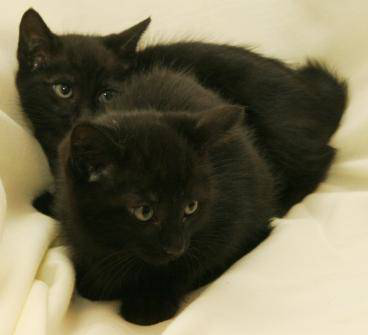

In [32]:
from PIL import Image
Image.open(path + 'test/' + filenames[0])

In [33]:
isdog = np.clip(preds[:,1], .05, .98)
isdog[:5]

array([ 0.05  ,  0.3333,  0.05  ,  0.05  ,  0.98  ], dtype=float32)

In [34]:
ids = [int(f[8:f.find('.')]) for f in filenames]
ids[:5]

[9451, 3140, 2665, 5136, 7523]

In [35]:
subm = np.stack([ids, isdog], axis = 1)
subm[:5]

array([[  9.4510e+03,   5.0000e-02],
       [  3.1400e+03,   3.3331e-01],
       [  2.6650e+03,   5.0000e-02],
       [  5.1360e+03,   5.0000e-02],
       [  7.5230e+03,   9.8000e-01]])

In [36]:
from operator import itemgetter
ordered_subm = sorted(subm, key=itemgetter(0))

In [37]:
ordered_subm[:5]

[array([ 4.  ,  0.98]),
 array([ 6.  ,  0.05]),
 array([ 20.  ,   0.05]),
 array([ 131.  ,    0.98]),
 array([ 459.  ,    0.98])]

In [38]:
np.savetxt(path + 'submission/subm.csv', ordered_subm, fmt='%d,%.5f', header = 'id, label', comments = '')

In [39]:
from IPython.display import FileLink
FileLink(path + 'submission/subm.csv')

/Users/mikewalker/fastai/nbs/kdata/redux/sample/submission/subm.csv

## Visualize results

## Make me blue

In [40]:
vgg.model.load_weights(path+'results/ft1.h5')

In [41]:
val_batches, probs = vgg.test(path+'valid', batch_size = batch_size)

Found 50 images belonging to 2 classes.


In [42]:
labels = val_batches.classes
filenames = val_batches.filenames

In [43]:
probs = probs[:,0]
preds = np.round(1-probs)
probs[0:8]

array([ 0.96  ,  0.0065,  1.    ,  0.9973,  1.    ,  1.    ,  0.9999,  1.    ], dtype=float32)

In [44]:
preds[0:8]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [45]:
n_view = 4

In [46]:
def plots_idx (idx, titles = None) :
    plots([image.load_img(path+"valid/" + filenames[i]) for i in idx], titles = titles)

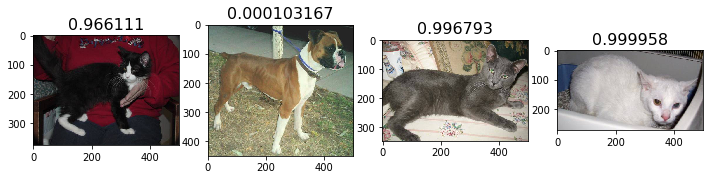

In [71]:
correct = np.where(preds==labels)[0]
idx = permutation(correct)[:n_view]
plots_idx(idx, probs[idx])

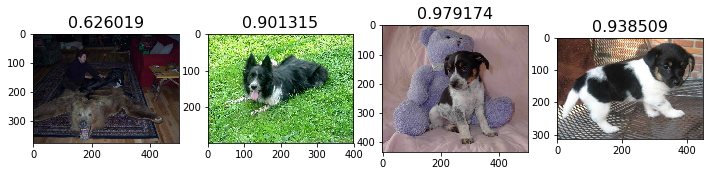

In [70]:
incorrect = np.where(preds!=labels)[0]
idx = permutation(incorrect)[:n_view]
plots_idx(idx, probs[idx])

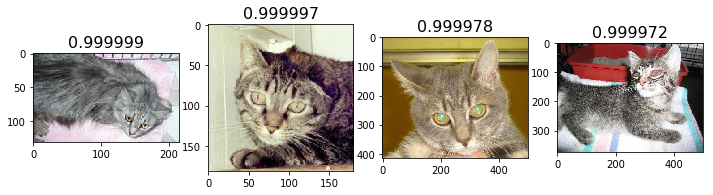

In [69]:
correct_cats = np.where((preds==0) & (preds==labels))[0]
most_correct_cats = np.argsort(probs[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], probs[correct_cats][most_correct_cats])

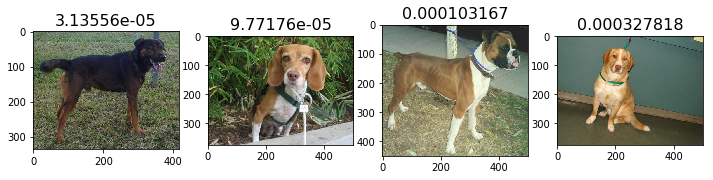

In [68]:
correct_dogs = np.where((preds==1) & (preds==labels))[0]
most_correct_dogs = np.argsort(probs[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], probs[correct_dogs][most_correct_dogs])

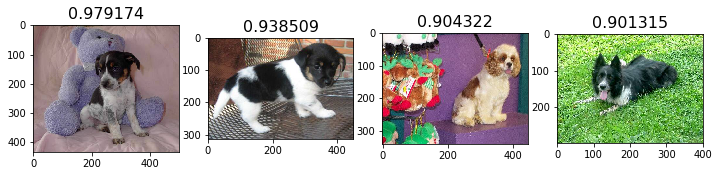

In [67]:
incorrect_cats = np.where((preds==0) & (preds!=labels))[0]
most_incorrect_cats = np.argsort(probs[incorrect_cats])[::-1][:n_view]
plots_idx(incorrect_cats[most_incorrect_cats], probs[incorrect_cats][most_incorrect_cats])

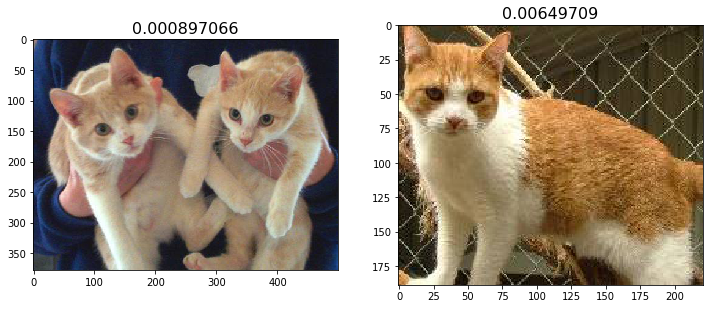

In [66]:
incorrect_dogs = np.where((preds==1) & (preds!=labels))[0]
most_incorrect_dogs = np.argsort(probs[incorrect_dogs])[:n_view]
plots_idx(incorrect_dogs[most_incorrect_dogs], probs[incorrect_dogs][most_incorrect_dogs])

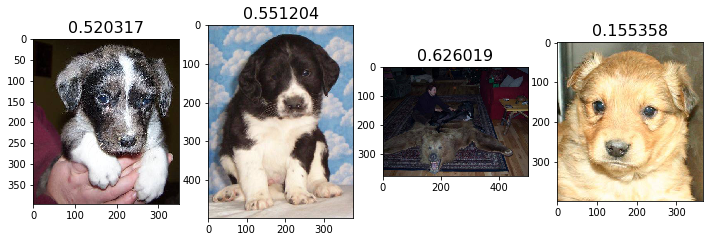

In [65]:
most_uncertain = np.argsort(np.abs(probs-0.5))
plots_idx(most_uncertain[:n_view], probs[most_uncertain])